<a href="https://colab.research.google.com/github/acf62/dcgan-colab/blob/master/64_E_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset and Inception score


In [0]:
%matplotlib inline

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import zipfile

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"0B7EVK8r0v71pZjFTYXZWM3FlRnM"})   
downloaded.GetContentFile('img_align_celeba.zip')

# path = "/content/drive/My Drive/Colab Notebooks"

# Root directory for dataset
dataroot = "data"

# Extract dataset
with zipfile.ZipFile('img_align_celeba.zip', 'r') as zip_ref:
    zip_ref.extractall(dataroot)

In [2]:
from torchvision.models.inception import inception_v3
from torch.autograd import Variable
from torch.nn import functional as F
from scipy.stats import entropy
import numpy as np

inception_model = inception_v3(pretrained=True).cuda()
inception_model.eval()

def inception_score(imgs, batch_size=32, splits=1):
    N = len(imgs)

    data_loader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    predictions = []
    upsample = nn.Upsample(size=(299, 299), mode='bilinear', align_corners=False).to(device)
    
    for i, batch in enumerate(data_loader):
        batch_v = Variable(upsample(batch.to(device)))
        output = inception_model(batch_v)
        prediction = F.softmax(output, dim=1).data.cpu().numpy()
        predictions.extend(prediction)

    # Computing the mean kl-div
    split_scores = []
 
    for j in range(splits):
        split = predictions[j * (N // splits) : (j+1) * (N // splits)]
        p_y = np.mean(split, axis=0)
        scores = []
        for i in range(len(split)):
            p_yx = split[i]
            scores.append(entropy(p_yx, p_y))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth


In [0]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data

from torchvision.models.inception import inception_v3

import numpy as np
from scipy.stats import entropy

def inception_score(imgs, cuda=True, batch_size=32, resize=True, splits=10):
    """Computes the inception score of the generated images imgs
    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    dtype = torch.cuda.FloatTensor


    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model

    up = nn.Upsample(size=(299, 299), mode='bilinear', align_corners=False).type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x, dim=1).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

# DCGAN and Criterion classes


In [0]:
import torch.nn as nn

# Number of channels
nc = 3

# Size of latent vector, ie generator input
nz = 100

# Size of feature maps in generator
nfg = 64

# Size of feature maps in discriminator
nfd = 64

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.optimizer = None
        self.criterion = None
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, nfg * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(nfg * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(nfg * 8, nfg * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfg * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(nfg * 4, nfg * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfg * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(nfg * 2, nfg * 1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfg * 1),
            nn.ReLU(True),

            nn.ConvTranspose2d(nfg * 1, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.optimizer = None
        self.criterion = None
        self.main = nn.Sequential(
            nn.Conv2d(nc, nfd, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nfd, nfd * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfd * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nfd * 2, nfd * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfd * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nfd * 4, nfd * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfd * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # nn.Conv2d(nfd * 8, 1, 4, 1, 0, bias=False),

            nn.Flatten(),
            nn.Linear(4*4*nfd*8, 1),

            nn.Sigmoid()   # Removed for LSGAN
        )

    def forward(self, x):
        return self.main(x)

In [0]:
# Learning criteria for the mutations
criteria = ['nsgan', 'vanilla', 'lsgan']

# Values of real and fake labels
real_label = 1
fake_label = 0

# Class abstracting the different criteria for the mutations
class Criterion(nn.Module):
    def __init__(self, loss_mode, is_generator, real_label=1.0, fake_label=0.0):
        super(Criterion, self).__init__()
        self.loss_mode = loss_mode
        self.is_generator = is_generator
        self.real_label = real_label
        self.fake_label = fake_label

    def G_loss(self, data):
        if self.loss_mode == 'nsgan':
            criterion = nn.BCELoss()
            labels_real = torch.full((batch_size, ), self.real_label, device=device)
            return criterion(data, labels_real)
        elif self.loss_mode == 'vanilla':
            criterion = nn.BCELoss()
            labels_fake = torch.full((batch_size, ), self.fake_label, device=device)
            return -criterion(data, labels_fake)
        elif self.loss_mode == 'lsgan':
            criterion = nn.MSELoss()
            labels_real = torch.full((batch_size, ), self.real_label, device=device)
            return criterion(data, labels_real)
        else:
            raise NotImplementedError("GAN loss mode %s is not recognised" % self.loss_mode)


    def D_loss(self, data, is_real):
        if self.loss_mode in ['nsgan', 'vanilla']:
            criterion = nn.BCELoss()
            if is_real:
                labels_real = torch.full((batch_size, ), self.real_label, device=device)
                return criterion(data, labels_real)
            else:
                labels_fake = torch.full((batch_size, ), self.fake_label, device=device)
                return criterion(data, labels_fake)
        elif self.loss_mode == 'lsgan':
            criterion = nn.MSELoss()
            if is_real:
                labels_real = torch.full((batch_size, ), self.real_label, device=device)
                return criterion(data, labels_real)
            else:
                labels_fake = torch.full((batch_size, ), self.fake_label, device=device)
                return criterion(data, labels_fake)
        else:
            raise NotImplementedError("GAN loss mode %s is not recognised" % self.loss_mode)


    def __call__(self, data, is_real):
        if self.is_generator:
            return self.G_loss(data) 
        else:
            return self.D_loss(data, is_real)

# Training

Initialize

In [0]:
#@title Initialization
import copy
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


# Number of generators
population_size = 1 #@param {type:"integer"}

# Number of mutations
num_mutations = 2 #@param {type:"slider", min:1, max:3, step:1}

# Number of training epochs
num_epochs = 10 #@param ["1", "2", "5", "10", "20"] {type:"raw", allow-input: true}

# How often to log performance of generators
log_every_steps = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Lambda for use in fitness function
lamba_f = 0.1


def initialize_weights(layer):
    classname = layer.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(layer.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(layer.weight.data, 1.0, 0.02)
        nn.init.constant_(layer.bias.data, 0)

# Number of GPUs available.
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Latent vectors for plotting the progress of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Lists to hold the data for plotting
img_list = []
D_losses = []
G_losses = [[] for _ in range(num_mutations)]
choices  = [[] for _ in range(num_mutations)]
inc_scores = []

# Create Generator list and Discriminator
G_population = [Generator(ngpu=ngpu).to(device) for _ in range(population_size)]
D = Discriminator(ngpu=ngpu).to(device)

# Initialize the network weights
[Gi.apply(initialize_weights) for Gi in G_population]
D.apply(initialize_weights)

# Optimizers and learning criteria for G and D
D.optimizer = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
D.criterion = Criterion(loss_mode='nsgan', is_generator=False)

for Gi in G_population: 
    Gi.optimizer = optim.Adam(Gi.parameters(), lr=lr, betas=(beta1, 0.999))
    Gi.criterion = Criterion(loss_mode='nsgan', is_generator=True)

Gradients and Optimization

In [0]:
# Get gradients of discriminator
def D_grad(Gi, data):
    # real samples
    D.zero_grad()
    real_imgs = data[0].to(device)
    output_real = D(real_imgs).view(-1)
    err_D_real = D.criterion(output_real, is_real=True)
    err_D_real.backward(retain_graph=True)
    D_x = output_real.mean().item()

    # fake samples
    noise = torch.randn(batch_size, nz, 1, 1, device=device)
    fake_imgs = Gi(noise)
    output_fake = D(fake_imgs.detach()).view(-1)
    err_D_fake = D.criterion(output_fake, is_real=False)
    err_D_fake.backward(retain_graph=True)
    err_D = err_D_real + err_D_fake
    D_Gi_z1 = output_fake.mean().item()

    return fake_imgs, D_x, D_Gi_z1, err_D

# Get gradients of generator given fake images
def G_grad(Gi, fake_imgs):
    fake_imgs = Gi(torch.randn(batch_size, nz, 1, 1, device=device))
    Gi.zero_grad()
    output = D(fake_imgs).view(-1)
    err_Gi = Gi.criterion(output, is_real=False)
    err_Gi.backward(retain_graph=True)
    D_Gi_z2 = output.mean().item()
    return err_Gi

# Take a Discriminator step
def D_step(Gi, data):
    fake_imgs, D_x, D_Gi_z1, err_D = D_grad(Gi, data)
    D.optimizer.step()
    return fake_imgs, D_x, D_Gi_z1, err_D

# Take a Generator step
def G_step(Gi, fake_imgs):
    err_Gi = G_grad(Gi, fake_imgs)
    Gi.optimizer.step()
    return err_Gi

Evolutionary Algorithm

In [0]:
# Print training statistics and save losses for plotting
def data_log(iters, epoch, data_length, err_D, D_x, D_G_z1, inception_mean, inception_std):
    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tD(x): %.4f\tD(G(z)): %.4f\tInception: %.4f ~ %.4f' 
        % (epoch+1, num_epochs, iters, data_length, err_D.item(), D_x, D_G_z1, inception_mean, inception_std))
            
    D_losses.append(err_D.item())
    inc_scores.append(inception_mean)

# Log image from fixed vector for plotting         
def image_log():
    with torch.no_grad():
        fake = G_population[0](fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

# Print the mutation selection rate for the current epoch
def selection_log(best_selections):
    print('Selections: ' + ''.join([(',' if i > 0 else '') 
              + '   %s->%d/%d' % (criteria[i], best_selections[i], sum(best_selections)) for i in range(num_mutations)]))           
    
    for i in range(num_mutations):
        choices[i].append(best_selections[i])

# Calculate the fitness function for a generator
def fitness(Gi, data):
    # Get varialbes needed for fitness  
    _, _, D_Gi_z1, err_D = D_grad(Gi, data)

    # Quality fitness score
    Fq = D_Gi_z1
    # Fq = inception_score(Gi(torch.randn(batch_size//8, nz, 1, 1, device=device)))[0]

    # Diversity fitness score
    gradients = torch.autograd.grad(outputs=err_D, inputs=D.parameters(),
                                    grad_outputs=torch.ones(err_D.size()).to(device),
                                    create_graph=True, retain_graph=True, only_inputs=True)
    
    with torch.no_grad():
        for i, grad in enumerate(gradients):
            grad = grad.view(-1)
            allgrad = grad if i == 0 else torch.cat([allgrad,grad]) 
    Fd = torch.log(torch.norm(allgrad))
    # print(Fq, Fd)
    return Fq + lamba_f*Fd

# Select the most fit generators
def selection(data):
    global G_population    
    # Calculate fitness scores
    scores = [fitness(Gi, data) for Gi in G_population]

    # Keep log of choice for plotting only if population_size == 1
    best_index = 0 if population_size != 1 else sorted(zip(scores, [0,1,2]), reverse=True)[0][1]

    # Select the best-performing generators
    G_population = [x for _, x in sorted(zip(scores, G_population), reverse=True, key=lambda s: s[0])]
    G_population = G_population[:population_size]

    return best_index

# Mutation function
def mutation(data, iters):
    global G_population
    # New population
    G_new = []

    # Repeat all generators in the population
    for i, Gi in enumerate(G_population):
        # Getting fake_imgs variable to use in mutation
        fake_imgs = Gi(torch.randn(batch_size, nz, 1, 1, device=device))
        
        # For all mutations
        for m_num in range(num_mutations):
            # Deep copy
            Gi_mutation = copy.deepcopy(Gi)
            # Apply mutation
            Gi_mutation.criterion = Criterion(loss_mode=criteria[m_num], is_generator=True)
            err_Gi = G_step(Gi_mutation, fake_imgs)
            # Add to new population
            G_new.append(Gi_mutation)

            # Log losses for all mutations to plot
            if (iters + 1) % log_every_steps == 0 and i == 0:
                G_losses[m_num].append(err_Gi.item())

        # for param_group in G_population[i].optimizer.param_groups:
        #     param_group['lr'] = lr*(1.5**(i-1))

    # Replace with new population
    G_population = G_new

def evolve(data_loader):
    for epoch in range(num_epochs):
        # Variable to hold best mutations for each step
        best_selections = [0] * num_mutations

        # Used for logging
        iters = 0
        for data in data_loader:
            # Train D
            fake_imgs, D_x, D_G0_z1, err_D = D_step(G_population[0], data)
            
            # Mutation
            mutation(data, iters)

            # Selection
            best_index = selection(data)

            if (iters + 1) % log_every_steps == 0:
                # Calculate inception score
                inception_mean, inception_std = inception_score(fake_imgs, splits=10)
                # Log for plotting
                data_log(iters, epoch, len(data_loader), err_D, D_x, D_G0_z1, inception_mean, inception_std)
            
            # Keep log of selections
            best_selections[best_index] +=1
            
            iters += 1
        # Log images and selections once every epoch
        image_log()
        if population_size == 1:
            selection_log(best_selections)

# Evaluation

In [0]:
import torch.utils.data
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np

# Number of workers for data_loader
workers = 2

# Batch size 
batch_size = 128

# Size of training images
image_size = 64

# Create the dataset
# dataset = dsets.ImageFolder(root='data',
#                            transform=transforms.Compose([
#                                transforms.Resize(image_size),
#                                transforms.CenterCrop(image_size),
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                            ]))
dataset = dsets.CelebA(root='data/celeba', download=True,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5,))
                           ]))


# Create the data_loader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)

# Start the evolution of the GAN
evolve(data_loader)

Files already downloaded and verified
[1/10][99/1271]	Loss_D: 0.0012	D(x): 0.9988	D(G(z)): 0.0000	Inception: 1.0535 ~ 0.0136
[1/10][199/1271]	Loss_D: 0.2563	D(x): 0.8838	D(G(z)): 0.0965	Inception: 1.0816 ~ 0.0239
[1/10][299/1271]	Loss_D: 0.4083	D(x): 0.7730	D(G(z)): 0.0948	Inception: 1.4535 ~ 0.1230


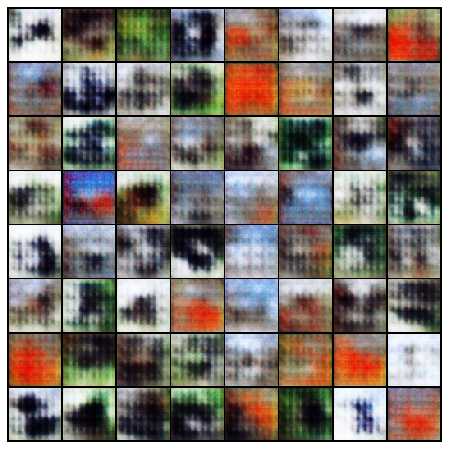

In [0]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i ,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

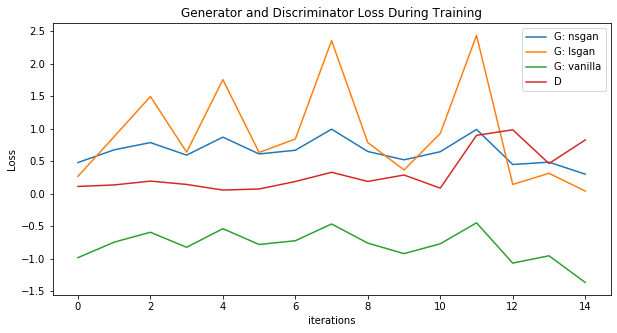

In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")

for i in range(num_mutations):
    plt.plot(G_losses[i],label="G: " + criteria[i])

plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

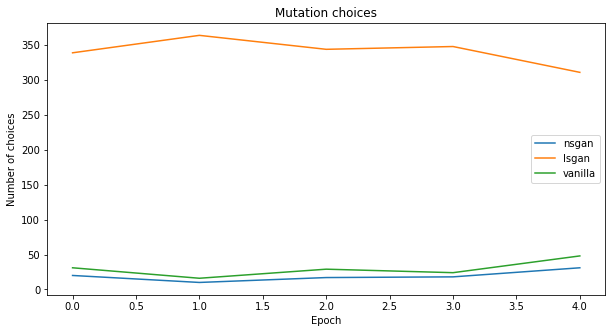

In [0]:
plt.figure(figsize=(10,5))
plt.title("Mutation choices")

for i in range(num_mutations):
    plt.plot(choices[i],label=criteria[i])

plt.xlabel("Epoch")
plt.ylabel("Number of choices")
plt.legend()
plt.show()

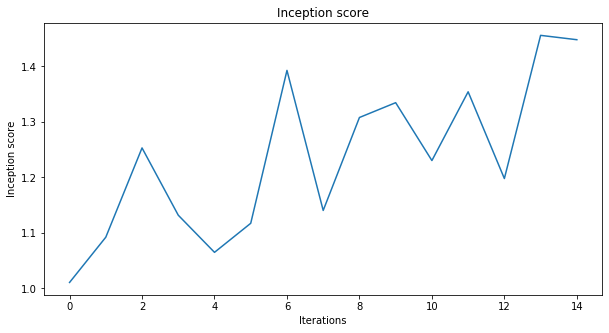

In [0]:
plt.figure(figsize=(10,5))
plt.title("Inception score")

plt.plot(inc_scores)

plt.xlabel("Iterations")
plt.ylabel("Inception score")
plt.show()

In [0]:
HTML(ani.to_jshtml())

In [0]:
#@title Parameter Change
num_epochs = 20  #@param ["1", "2", "5", "10", "20"] {type:"raw", allow-input: true}

num_mutations = 1 #@param {type:"slider", min:1, max:3, step:1}

# Load/Save to Drive


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#@title Save Models

slot = "celebA-64" #@param ["cifar10", "celebA"] {allow-input: true}

g_save_name = 'edcgan-G-%s.pt' % slot
path = "/content/drive/My Drive/Colab Notebooks/Models/" + g_save_name
torch.save(G_population[0].state_dict(), path)

d_save_name = 'edcgan-D-%s.pt' % slot
path = "/content/drive/My Drive/Colab Notebooks/Models/" + d_save_name
torch.save(D.state_dict(), path)

In [0]:
#@title Load Models

slot = "cifar10" #@param ["cifar10", "celebA"] {allow-input: true}

g_save_name = 'edcgan-G-%s.pt' % slot
path = "/content/drive/My Drive/Colab Notebooks/Models/" + g_save_name
G[0].load_state_dict(torch.load(path))

d_save_name = 'edcgan-D-%s.pt' % slot
path = "/content/drive/My Drive/Colab Notebooks/Models/" + d_save_name
D.load_state_dict(torch.load(path))

<All keys matched successfully>